# Collaborators Whereabouts
Author: Sam Eriksen

Description: Notebook to read in collaboration list from google sheets and plot

In [25]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import geopy.distance as dist
import airportsdata
from geopy.distance import great_circle
import requests
import matplotlib
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import io
import sys
sys.path.append('../src/sustainable_lz/')
from flights_v2 import flight_emission_calc_v2
flight_co2_100yr=flight_emission_calc_v2(emission_factor=1.7)
flight_co2_30yr=flight_emission_calc_v2(emission_factor=3.)

from author_list_utilities import author_list_util


def cross_calc(data,func,key):
    """
        Defining this here as it requires the two sparate modules
    """
    cumulative_distance=[]
    for index,institute in data.iterrows():
        total_distance=0
        for other_index,other_institute in data.iterrows():
            if index==other_index:
                continue
            total_distance+=other_institute['author_count']*func(dist.distance(
                                         (institute['latitude'],institute['longitude']),
                                         (other_institute['latitude'],other_institute['longitude'])).km)

        cumulative_distance.append(total_distance)

    data[key]=cumulative_distance

def plot_sites(institution_dist,key='cumulative_CO2e_30yr',normalisation=1):
    """
        institution_dist : data frame of instiutions
        nomralisation : something to scale the CO2e or distance by
        key : what to put on the colorbar
    """

    longs=np.array(institution_dist.sort_values(by=[key])['longitude'])
    lats=np.array(institution_dist.sort_values(by=[key])['latitude'])


    world = gpd.read_file('../data/maps/ne_110m_admin_0_countries.shp')
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    carbon_map = matplotlib.colormaps['summer']
    world.boundary.plot(ax=ax, zorder=1) 
    max_marker=150
    min_marker=50

    for i,(long,lat) in enumerate(np.transpose([longs,lats])):
        color=carbon_map(i/len(longs))
        ax.scatter(long,lat, marker='*', color=color,s=100)

    cmap = carbon_map
    min_dist=max(institution_dist[key])*normalisation
    max_dist=min(institution_dist[key])*normalisation
    norm = matplotlib.colors.Normalize(vmin=min_dist, vmax=max_dist)

    clb=plt.colorbar(matplotlib.cm.ScalarMappable(cmap=carbon_map,norm=norm),ax=plt.gca(),shrink=0.4,
                 label='tCO2e of flights',ticks=np.linspace(min_dist,max_dist,5,endpoint=True),
                format='%.1f')
    clb.set_label('tCO2e for every Author',fontsize=18)
    plt.xlim([-140,155])
    plt.ylim([-40,60])
    plt.xlabel("longitude ($^\circ$)",fontsize=18)
    plt.ylabel("latitude ($^\circ$)",fontsize=18)
    clb.ax.tick_params(labelsize='large')
    return clb

# Initliase the author list

In [3]:
attendees=pd.read_csv('../data/LZ_Brown_collab_24_attendence.csv')
attendees['FirstName']=attendees['First Name']
attendees['LastName']=attendees['Last name']
author_list=author_list_util(attendance_list_df=attendees)

/home/frodo/downlaoded_sus_lz/sustainable_lz/brown_transport/git_sus_lz/notebooks/../src/sustainable_lz/author_list_utilities.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.authorship_list['Attended']=True


Attendence was 18.0%
Finding Instituition locations


RateLimiter caught an error, retrying (0/2 tries). Called with (*('University of California, Berkeley (Engineering)',), **{}).
Traceback (most recent call last):
  File "/home/frodo/anaconda3/envs/flamedisx/lib/python3.11/site-packages/urllib3/connectionpool.py", line 536, in _make_request
    response = conn.getresponse()
               ^^^^^^^^^^^^^^^^^^
  File "/home/frodo/anaconda3/envs/flamedisx/lib/python3.11/site-packages/urllib3/connection.py", line 464, in getresponse
    httplib_response = super().getresponse()
                       ^^^^^^^^^^^^^^^^^^^^^
  File "/home/frodo/anaconda3/envs/flamedisx/lib/python3.11/http/client.py", line 1395, in getresponse
    response.begin()
  File "/home/frodo/anaconda3/envs/flamedisx/lib/python3.11/http/client.py", line 325, in begin
    version, status, reason = self._read_status()
                              ^^^^^^^^^^^^^^^^^^^
  File "/home/frodo/anaconda3/envs/flamedisx/lib/python3.11/http/client.py", line 286, in _read_status
    l

Daejeon, KOR


/home/frodo/downlaoded_sus_lz/sustainable_lz/brown_transport/git_sus_lz/notebooks/../src/sustainable_lz/author_list_utilities.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.author_university_locations["author_count"] = self.institutions['University'].map(author_counts)


Get university address information

Plot on a map all universities involved

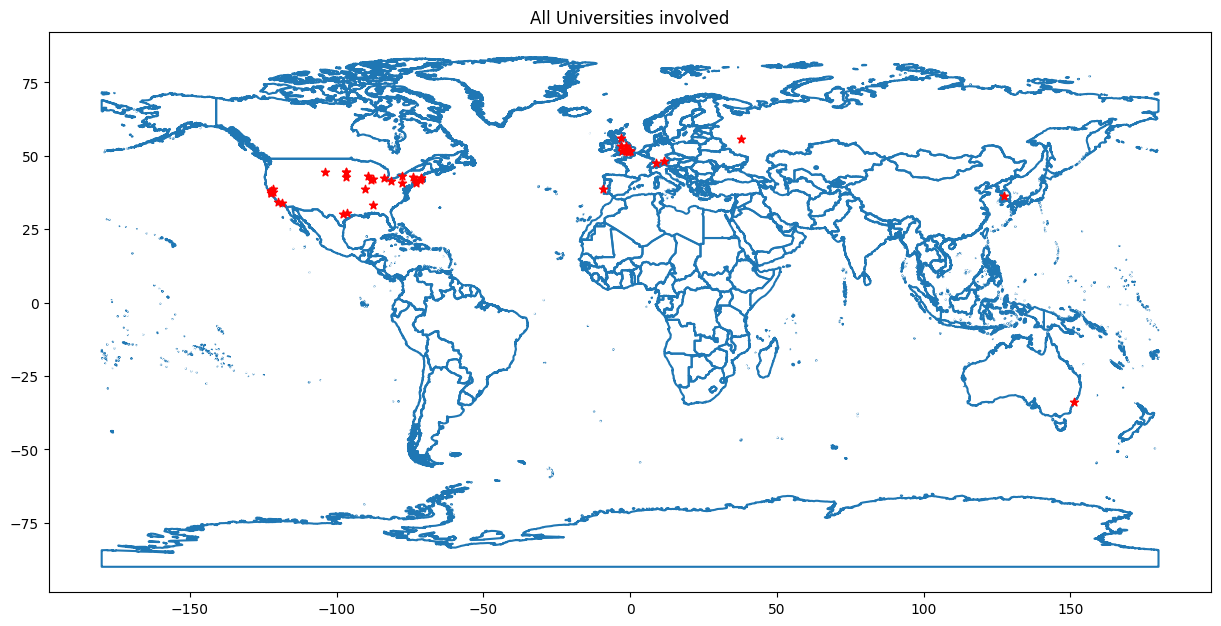

In [5]:
world = gpd.read_file('../data/maps/ne_10m_admin_0_countries.shp')
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

world.boundary.plot(ax=ax, zorder=1) 
ax.scatter(author_list.institutions['longitude'],author_list.institutions['latitude'], marker='*', color='red', zorder=2)

ax.set_title('All Universities involved')
plt.show()

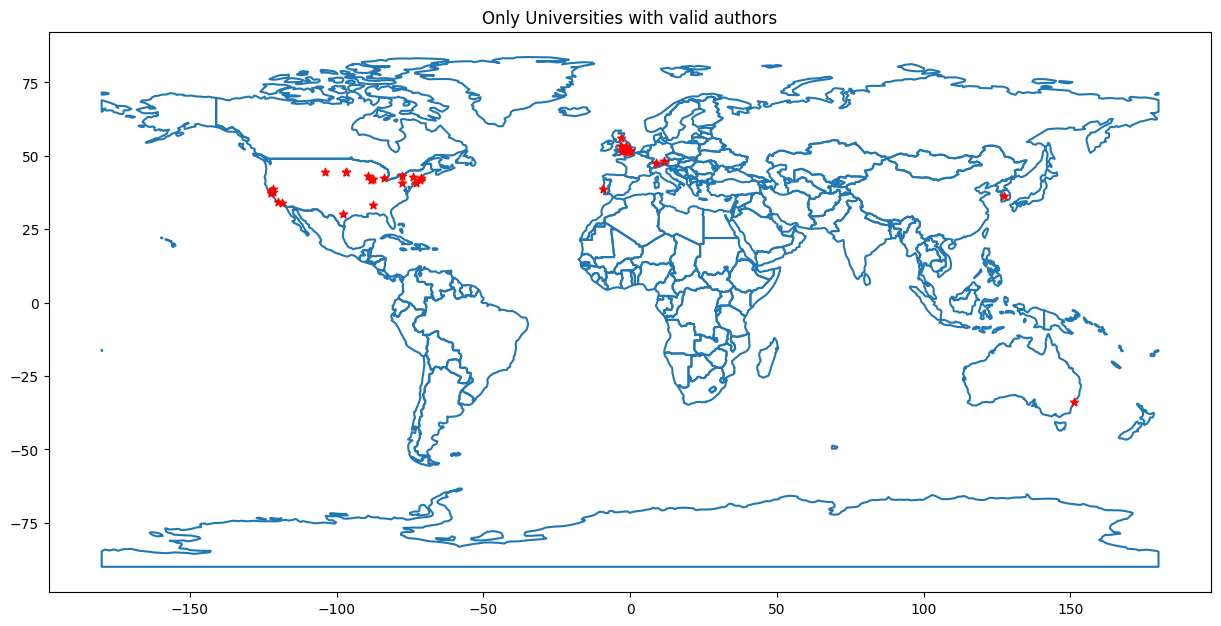

In [6]:
world = gpd.read_file('../data/maps/ne_110m_admin_0_countries.shp')
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

 
author_list.filter_to_authors()

world.boundary.plot(ax=ax, zorder=1) 
ax.scatter(author_list.institutions['longitude'],author_list.institutions['latitude'], marker='*', color='red', zorder=2)


grouped_by_country_or_state=author_list.group_by_country_or_state()
author_list.remove_filters()
# author_list.remove_filter_to_authors()
ax.set_title('Only Universities with valid authors')
plt.show()

In [7]:
author_list['Attended']

6      False
7      False
9      False
10     False
11     False
       ...  
832    False
833    False
834    False
835    False
836    False
Name: Attended, Length: 557, dtype: bool

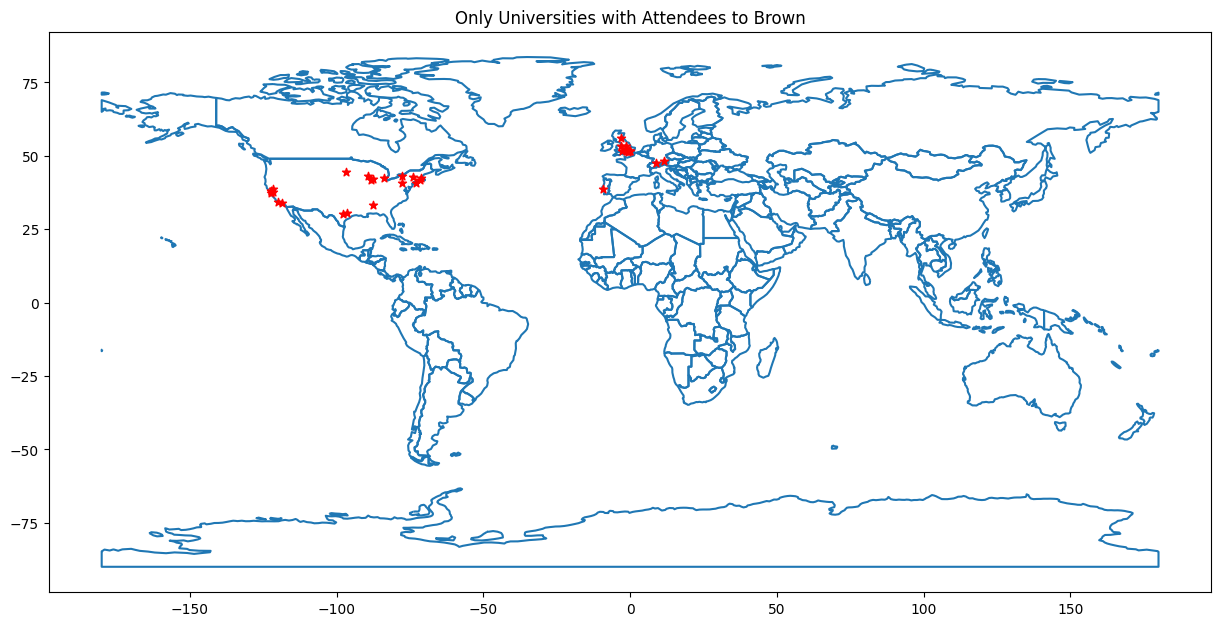

In [8]:
world = gpd.read_file('../data/maps/ne_110m_admin_0_countries.shp')
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

 
author_list.filter_to_attendees()

world.boundary.plot(ax=ax, zorder=1) 
ax.scatter(author_list.institutions['longitude'],author_list.institutions['latitude'], marker='*', color='red', zorder=2)


grouped_by_country_or_state=author_list.group_by_country_or_state()
# author_list.remove_filters()
# author_list.remove_filter_to_authors()
ax.set_title('Only Universities with Attendees to Brown')
plt.show()

# Code to calculate CO2 to every other location, could probably wrap up a bit nicer

# Calculate assuming all attendees 
We only expected 74 of the 100 to fly due to virtual or being close, may need to cut on data frame to remove local as they would not fly

Lowest Three given attendees


,University,Address,Universities_FullName,Short_Address,Corrected_Name,Start_Address,location,longitude,latitude,author_count,cumulative_CO2e_100yr,cumulative_CO2e_30yr
24,University at Albany (SUNY),"Department of Physics, 1400 Washington Avenue,...","University at Albany (SUNY), Department of Phy...","NY 12222-1000, USA",University at Albany,"Department of Physics, 1400 Washington Avenue","(University at Albany, The State University of...",-73.825877,42.684027,6,74.067334,123.858786
38,University of Rochester,"Department of Physics and Astronomy, Rochester...","University of Rochester, Department of Physics...","NY 14627-0171, USA",University of Rochester,"Department of Physics and Astronomy, Rochester","(University of Rochester River Campus, Gold St...",-77.628784,43.129864,1,74.550010,124.596887
7,Brown University,"Department of Physics, 182 Hope Street, Provid...","Brown University, Department of Physics, 182 H...","RI 02912-9037, USA",Brown University,"Department of Physics, 182 Hope Street","(Brown University, South Main Street, Fox Poin...",-71.408801,41.818640,5,75.343440,126.002589


Greatest Three given attendees


,University,Address,Universities_FullName,Short_Address,Corrected_Name,Start_Address,location,longitude,latitude,author_count,cumulative_CO2e_100yr,cumulative_CO2e_30yr
12,Laboratório de Instrumentação e Física Experim...,"Department of Physics, University of Coimbra, ...",Laboratório de Instrumentação e Física Experim...,"Coimbra, Portugal",Laboratório de Instrumentação e Física Experim...,"Department of Physics, University of Coimbra",(LIP - Laboratório de Instrumentação e Física ...,-9.143368,38.739920,1,123.437690,207.371658
50,University of Zurich,"Department of Physics, University of Zurich, W...","University of Zurich, Department of Physics, U...","8057 Zurich, Switzerland",University of Zurich,"Department of Physics, University of Zurich",(Zürcher Hochschule für Angewandte Wissenschaf...,8.729807,47.496843,3,127.457421,214.215573
34,University of Maryland,"Department of Physics, College Park, MD 20742-...","University of Maryland, Department of Physics,...","MD 20742-4111, USA",University of Maryland,"Department of Physics, College Park","(University of Maryland, Stadelheim, Obergiesi...",11.582349,48.098982,6,129.731985,218.115081


,University,Address,Universities_FullName,Short_Address,Corrected_Name,Start_Address,location,longitude,latitude,author_count,cumulative_CO2e_100yr,cumulative_CO2e_30yr
30,"University of California, Los Angeles","Department of Physics & Astronomy, Los Angeles...","University of California, Los Angeles, Departm...","CA 90095-1547, USA","University of California, Los Angeles","Department of Physics & Astronomy, Los Angeles","(University of California, Los Angeles, Medica...",-118.44685,34.070878,3,103.965181,174.440195


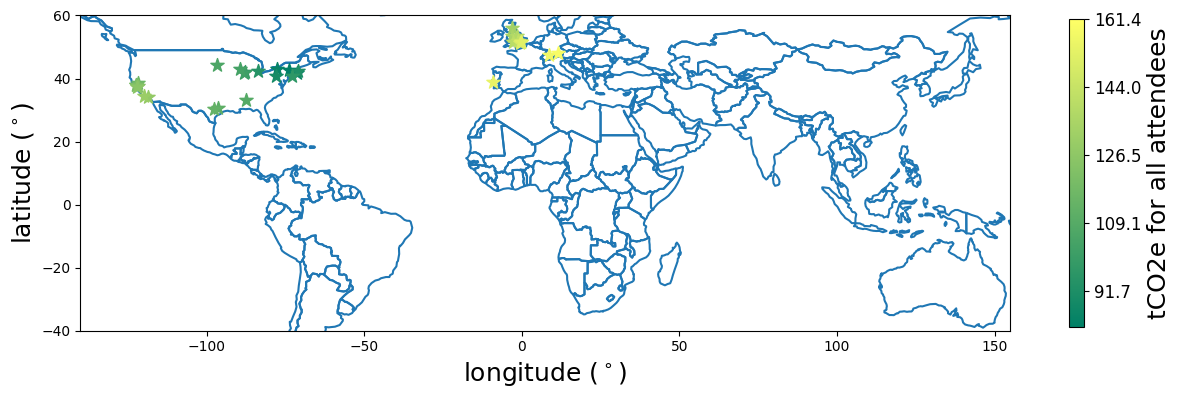

In [57]:
author_list.remove_filters()
author_list.filter_to_attendees()
#filtering rn reclaulates the author_university_locations dataframe 
cross_calc(author_list.author_university_locations,flight_co2_100yr.calc_emissions_v2,'cumulative_CO2e_100yr')
cross_calc(author_list.author_university_locations,flight_co2_30yr.calc_emissions_v2,'cumulative_CO2e_30yr')
clb=plot_sites(author_list.author_university_locations,normalisation=74/100)
clb.set_label('tCO2e for all attendees',fontsize=18)
print("Lowest Three given attendees")
display(author_list.author_university_locations.sort_values(by=['cumulative_CO2e_100yr']).iloc[:3],)
print("Greatest Three given attendees")
display(author_list.author_university_locations.sort_values(by=['cumulative_CO2e_100yr']).iloc[-3:])
print("For LA")
author_list.author_university_locations.loc[author_list.author_university_locations['University'] == 'University of California, Los Angeles']

# calculate assuming average fliers from the authorship list
The scaling here would be the fliers (74) divided by the number of authors

Lowest Three given attendees


,University,Address,Universities_FullName,Short_Address,Corrected_Name,Start_Address,location,longitude,latitude,author_count,cumulative_CO2e_100yr,cumulative_CO2e_30yr
38,University of Rochester,"Department of Physics and Astronomy, Rochester...","University of Rochester, Department of Physics...","NY 14627-0171, USA",University of Rochester,"Department of Physics and Astronomy, Rochester","(University of Rochester River Campus, Gold St...",-77.628784,43.129864,6,180.318787,301.720578
24,University at Albany (SUNY),"Department of Physics, 1400 Washington Avenue,...","University at Albany (SUNY), Department of Phy...","NY 12222-1000, USA",University at Albany,"Department of Physics, 1400 Washington Avenue","(University at Albany, The State University of...",-73.825877,42.684027,6,180.948113,302.783339
7,Brown University,"Department of Physics, 182 Hope Street, Provid...","Brown University, Department of Physics, 182 H...","RI 02912-9037, USA",Brown University,"Department of Physics, 182 Hope Street","(Brown University, South Main Street, Fox Poin...",-71.408801,41.818640,9,182.686146,305.772142


Greatest Three given attendees


,University,Address,Universities_FullName,Short_Address,Corrected_Name,Start_Address,location,longitude,latitude,author_count,cumulative_CO2e_100yr,cumulative_CO2e_30yr
34,University of Maryland,"Department of Physics, College Park, MD 20742-...","University of Maryland, Department of Physics,...","MD 20742-4111, USA",University of Maryland,"Department of Physics, College Park","(University of Maryland, Stadelheim, Obergiesi...",11.582349,48.098982,8,282.966553,475.570530
8,Center for Underground Physics (CUP),"IBS Center for Underground Physics 70, Yuseong...","Center for Underground Physics (CUP), IBS Cent...","Daejeon, KOR",Center for Underground Physics,"IBS Center for Underground Physics 70, Yuseong...",None,127.384520,36.375394,2,517.491332,872.564363
48,University of Sydney,"School of Physics, Physics Road, The Universit...","University of Sydney, School of Physics, Physi...","NSW 2006, Australia",University of Sydney,"School of Physics, Physics Road","(The University of Sydney, University Avenue, ...",151.189411,-33.888907,1,976.081180,1649.336029


For LA


,University,Address,Universities_FullName,Short_Address,Corrected_Name,Start_Address,location,longitude,latitude,author_count,cumulative_CO2e_100yr,cumulative_CO2e_30yr
30,"University of California, Los Angeles","Department of Physics & Astronomy, Los Angeles...","University of California, Los Angeles, Departm...","CA 90095-1547, USA","University of California, Los Angeles","Department of Physics & Astronomy, Los Angeles","(University of California, Los Angeles, Medica...",-118.44685,34.070878,3,250.887839,421.172063


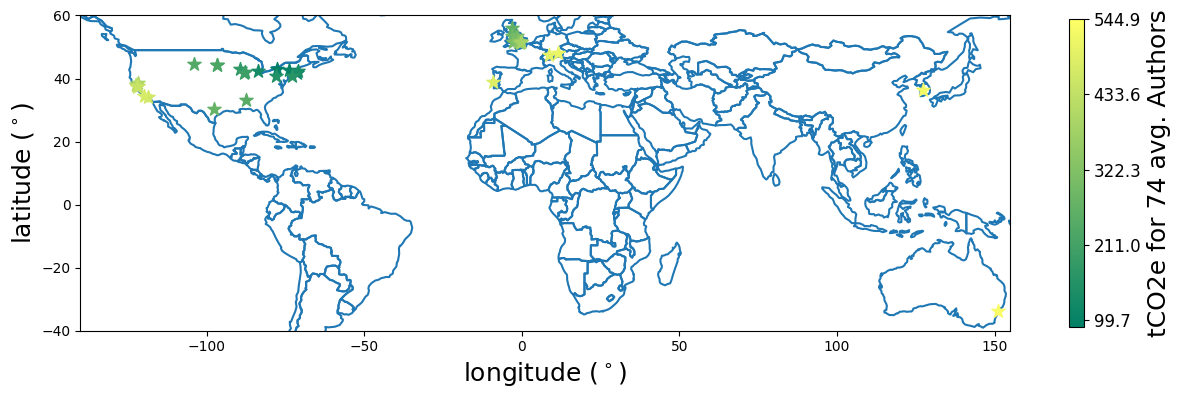

In [58]:
author_list.remove_filters()
author_list.filter_to_authors()
#filtering rn reclaulates the author_university_locations dataframe 
cross_calc(author_list.author_university_locations,flight_co2_100yr.calc_emissions_v2,'cumulative_CO2e_100yr')
cross_calc(author_list.author_university_locations,flight_co2_30yr.calc_emissions_v2,'cumulative_CO2e_30yr')
clb=plot_sites(author_list.author_university_locations,normalisation=74/np.sum(author_list.author_university_locations['author_count']))
clb.set_label('tCO2e for 74 avg. Authors',fontsize=18)
print("Lowest Three given attendees")
display(author_list.author_university_locations.sort_values(by=['cumulative_CO2e_100yr']).iloc[:3],)
print("Greatest Three given attendees")
display(author_list.author_university_locations.sort_values(by=['cumulative_CO2e_100yr']).iloc[-3:])
print("For LA")
author_list.author_university_locations.loc[author_list.author_university_locations['University'] == 'University of California, Los Angeles']

# what about just everyone on the list

Lowest Three given attendees


,University,Address,Universities_FullName,Short_Address,Corrected_Name,Start_Address,location,longitude,latitude,author_count,cumulative_CO2e_100yr,cumulative_CO2e_30yr
38,University of Rochester,"Department of Physics and Astronomy, Rochester...","University of Rochester, Department of Physics...","NY 14627-0171, USA",University of Rochester,"Department of Physics and Astronomy, Rochester","(University of Rochester River Campus, Gold St...",-77.628784,43.129864,11.0,428.084610,715.853106
36,University of Michigan,"Randall Laboratory of Physics, 450 Church Stre...","University of Michigan, Randall Laboratory of ...","MI 48109-1040, USA",University of Michigan,"Randall Laboratory of Physics, 450 Church Street","(University of Michigan, 500, South State Stre...",-83.710039,42.294214,19.0,428.840977,717.270967
41,University of Wisconsin-Madison,"Department of Physics, 1150 University Avenue ...","University of Wisconsin-Madison, Department of...","WI 53706-1390, USA",University of Wisconsin-Madison,"Department of Physics, 1150 University Avenue ...","(University of Wisconsin-Madison, Quarry Trail...",-89.430959,43.080274,17.0,431.891612,722.410415


Greatest Three given attendees


,University,Address,Universities_FullName,Short_Address,Corrected_Name,Start_Address,location,longitude,latitude,author_count,cumulative_CO2e_100yr,cumulative_CO2e_30yr
15,National Research Nuclear University MEPhI (NR...,"31 Kashirskoe shosse, Moscow, 115409, RUS",National Research Nuclear University MEPhI (NR...,"115409, RUS",National Research Nuclear University MEPhI,"31 Kashirskoe shosse, Moscow",(Национальный исследовательский ядерный универ...,37.665800,55.650451,6.0,842.921408,1418.120517
8,Center for Underground Physics (CUP),"IBS Center for Underground Physics 70, Yuseong...","Center for Underground Physics (CUP), IBS Cent...","Daejeon, KOR",Center for Underground Physics,"IBS Center for Underground Physics 70, Yuseong...",None,127.384520,36.375394,6.0,1299.473828,2191.212548
48,University of Sydney,"School of Physics, Physics Road, The Universit...","University of Sydney, School of Physics, Physi...","NSW 2006, Australia",University of Sydney,"School of Physics, Physics Road","(The University of Sydney, University Avenue, ...",151.189411,-33.888907,4.0,2382.462010,4025.609529


For LA


,University,Address,Universities_FullName,Short_Address,Corrected_Name,Start_Address,location,longitude,latitude,author_count,cumulative_CO2e_100yr,cumulative_CO2e_30yr
30,"University of California, Los Angeles","Department of Physics & Astronomy, Los Angeles...","University of California, Los Angeles, Departm...","CA 90095-1547, USA","University of California, Los Angeles","Department of Physics & Astronomy, Los Angeles","(University of California, Los Angeles, Medica...",-118.44685,34.070878,4.0,578.221929,969.96295


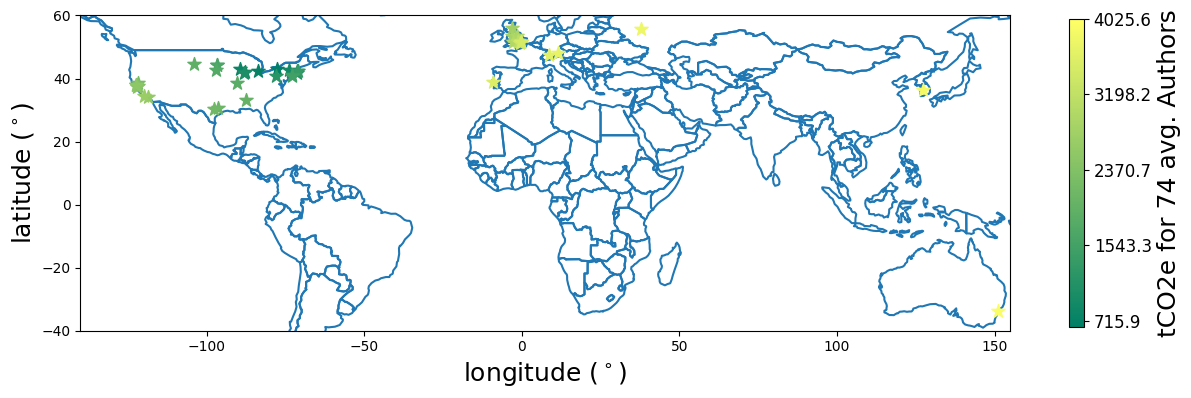

In [59]:
author_list.remove_filters()

#filtering rn reclaulates the author_university_locations dataframe 
cross_calc(author_list.author_university_locations,flight_co2_100yr.calc_emissions_v2,'cumulative_CO2e_100yr')
cross_calc(author_list.author_university_locations,flight_co2_30yr.calc_emissions_v2,'cumulative_CO2e_30yr')
clb=plot_sites(author_list.author_university_locations,normalisation=1)
clb.set_label('tCO2e for 74 avg. Authors',fontsize=18)
print("Lowest Three given attendees")
display(author_list.author_university_locations.sort_values(by=['cumulative_CO2e_100yr']).iloc[:3],)
print("Greatest Three given attendees")
display(author_list.author_university_locations.sort_values(by=['cumulative_CO2e_100yr']).iloc[-3:])
print("For LA")
author_list.author_university_locations.loc[author_list.author_university_locations['University'] == 'University of California, Los Angeles']

# what about three-hubs?

West Coast
                                      University  \
13  Lawrence Berkeley National Laboratory (LBNL)   
19          SLAC National Accelerator Laboratory   
28            University of California, Berkeley   

                                              Address  \
13     1 Cyclotron Road, Berkeley, CA 94720-8099, USA   
19  2575 Sand Hill Road, Menlo Park, CA 94205-7015...   
28  Department of Physics, 366 LeConte Hall MC 730...   

                                Universities_FullName       Short_Address  \
13  Lawrence Berkeley National Laboratory (LBNL), ...  CA 94720-8099, USA   
19  SLAC National Accelerator Laboratory, 2575 San...  CA 94205-7015, USA   
28  University of California, Berkeley, Department...  CA 94720-7300, USA   

                           Corrected_Name  \
13  Lawrence Berkeley National Laboratory   
19   SLAC National Accelerator Laboratory   
28     University of California, Berkeley   

                                      Start_Address  \
13    

/tmp/ipykernel_25479/861034181.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[key]=cumulative_distance
/tmp/ipykernel_25479/861034181.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[key]=cumulative_distance
/tmp/ipykernel_25479/861034181.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

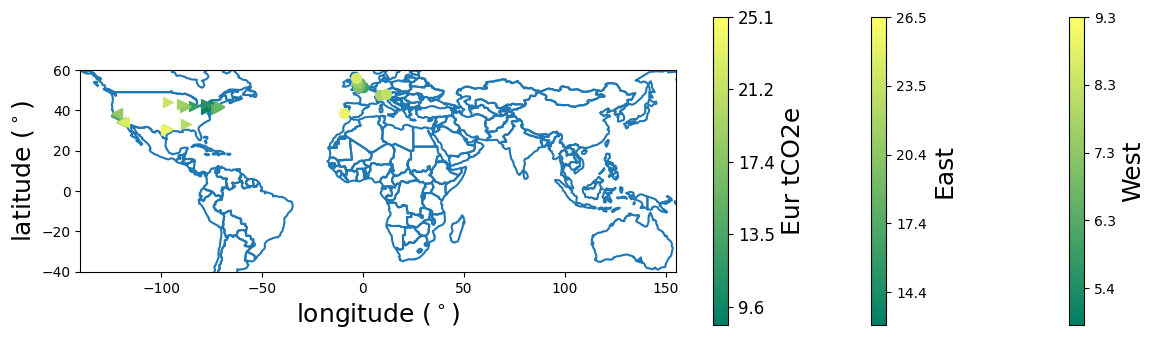

In [64]:
author_list.remove_filters()
author_list.filter_to_attendees()

key='cumulative_CO2e_100yr'
print("West Coast")
west_coast_cut=(author_list.author_university_locations['longitude']<-110)
west_author_dists=author_list.author_university_locations[west_coast_cut]
cross_calc(west_author_dists,flight_co2_100yr.calc_emissions_v2,key)
cross_calc(west_author_dists,flight_co2_30yr.calc_emissions_v2,key)

print(west_author_dists.sort_values(by=[key])[:3])



print("East Coast")

east_coast_cut=(author_list.author_university_locations['longitude']>-100)&(author_list.author_university_locations['longitude']<-25)
east_author_dists=author_list.author_university_locations[east_coast_cut]
cross_calc(east_author_dists,flight_co2_100yr.calc_emissions_v2,key)
cross_calc(east_author_dists,flight_co2_30yr.calc_emissions_v2,key)

print(east_author_dists.sort_values(by=[key])[:3])


print("Europe")
europe=(author_list.author_university_locations['longitude']>-25)&(author_list.author_university_locations['longitude']<110)
europe_author_dists=author_list.author_university_locations[europe]
cross_calc(europe_author_dists,flight_co2_100yr.calc_emissions_v2,key)
cross_calc(europe_author_dists,flight_co2_30yr.calc_emissions_v2,key)



print(europe_author_dists.sort_values(by=[key])[:3])





world = gpd.read_file('../data/maps/ne_110m_admin_0_countries.shp')
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
carbon_map = matplotlib.colormaps['summer']
world.boundary.plot(ax=ax, zorder=1) 

markers=['<','>','o']
labels=['West','East','Eur']
for j,author_dists in enumerate([west_author_dists,east_author_dists,europe_author_dists]):
    longs=np.array(author_dists.sort_values(by=[key])['longitude'])
    lats=np.array(author_dists.sort_values(by=[key])['latitude'])
    for i,(long,lat) in enumerate(np.transpose([longs,lats])):
        color=carbon_map(i/len(longs))
        ax.scatter(long,lat, marker=markers[j], color=color,s=50)

    cmap = carbon_map
    min_dist=max(author_dists[key])
    max_dist=min(author_dists[key])
    norm = matplotlib.colors.Normalize(vmin=min_dist, vmax=max_dist)

    clb=plt.colorbar(matplotlib.cm.ScalarMappable(cmap=carbon_map,norm=norm),ax=plt.gca(),shrink=0.4,
                 label='tCO2e of flights',ticks=np.linspace(min_dist,max_dist,5,endpoint=True),
                format='%.1f')

    clb.set_label(f'{labels[j]}',fontsize=18)
    if j==2:
        clb.set_label(f'{labels[j]} tCO2e',fontsize=18)
plt.xlim([-140,155])
plt.ylim([-40,60])
plt.xlabel("longitude ($^\circ$)",fontsize=18)
plt.ylabel("latitude ($^\circ$)",fontsize=18)
clb.ax.tick_params(labelsize='large')

# Try better plotting

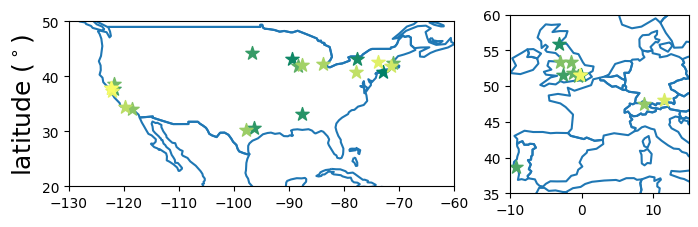

In [12]:
fig,axs=plt.subplots(1,2,figsize=(8,4),width_ratios=[70/25,1.3],height_ratios=[1])

longs=np.array(author_list.author_university_locations.sort_values(by=['author_count'])['longitude'])
lats=np.array(author_list.author_university_locations.sort_values(by=['author_count'])['latitude'])
author_count=np.array(author_list.author_university_locations['author_count'])

world = gpd.read_file('../data/maps/ne_110m_admin_0_countries.shp')


def plot_region(ax,xlims=[-140,155],ylims=[-40,60],labels=[True,True]):
    carbon_map = matplotlib.colormaps['summer']
    world.boundary.plot(ax=ax, zorder=1) 
    #lazy, plot them all not a sub-section, let limits cut them out 
    for i,(long,lat) in enumerate(np.transpose([longs,lats])):
        if long<xlims[0] or long>xlims[1]:
            continue
        if lat<ylims[0] or lat>ylims[1]:
            continue
        color=carbon_map(i/len(longs))
        ax.scatter(long,lat, marker='*', color=color,s=100)
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    if labels[0]:
        ax.set_xlabel("longitude ($^\circ$)",fontsize=18)
    if labels[1]:
        ax.set_ylabel("latitude ($^\circ$)",fontsize=18)



    
plot_region(axs[0],xlims=[-130,-60],ylims=[20,50],labels=[False,True])
plot_region(axs[1],xlims=[-10,15],ylims=[35,60],labels=[False,False])
# plot_region(axs[2],xlims=[120,155],ylims=[-40,-15],labels=[False,False])

# cmap = carbon_map
# min_dist=max(author_count)
# max_dist=min(author_count)
# norm = matplotlib.colors.Normalize(vmin=min_dist, vmax=max_dist)
# clb=plt.colorbar(matplotlib.cm.ScalarMappable(cmap=carbon_map,norm=norm),ax=plt.gca(),shrink=0.4,
#              label='tCO2e of flights',ticks=np.linspace(min_dist,max_dist,5,endpoint=True),
#             format='%.1f')
# clb.set_label('Authors',fontsize=18)
# clb.ax.tick_params(labelsize='large')
# fig.tight_layout()

# code to start looking for nearest airports and do a API? 

In [13]:


airports = airportsdata.load('IATA')
airports_df = pd.DataFrame.from_dict(airports, orient='index')

def find_nearest_airports(lat, lon, top_n=3): # assume one of the top 3 is a 'proper airport'
    # Calculate distances and add them as a new column
    airports_df['distance'] = airports_df.apply(
        lambda row: great_circle((lat, lon), (row['lat'], row['lon'])).km,
        axis=1
    )
    
    # Sort the DataFrame by distance
    sorted_airports_df = airports_df.sort_values(by='distance')
    
    # Select the top N nearest airports
    nearest_airports = sorted_airports_df.head(top_n)
    
    return nearest_airports[['iata', 'distance']].values.tolist()

def get_nearest_airports(row):
    return find_nearest_airports(row['latitude'], row['longitude'])

author_aiports_df = grouped_by_country_or_state
author_aiports_df['Airports'] = author_aiports_df.apply(get_nearest_airports, axis=1)

In [14]:
author_aiports_df

,Binning1,author_count,University,longitude,latitude,Airports
0,Alabama,1,University of Alabama,-87.539673,33.212082,"[[TCL, 6.739840206642885], [AIV, 62.3161082287..."
1,California,29,Lawrence Berkeley National Laboratory (LBNL),-122.245630,37.876959,"[[OAK, 17.447245242661477], [CCR, 20.761000720..."
2,Deutschland,6,University of Maryland,11.582349,48.098982,"[[OBF, 22.312174397229704], [FEL, 26.227866715..."
3,Illinois,5,Fermi National Accelerator Laboratory (FNAL),-88.245782,41.842258,"[[DPA, 7.206869664300017], [AUZ, 20.5968147225..."
4,Massachusetts,2,University of Massachusetts,-71.096627,42.358253,"[[BOS, 7.432561088477726], [OWD, 19.6785139514..."
5,Michigan,4,University of Michigan,-83.710039,42.294214,"[[ARB, 8.452609719653305], [YIP, 20.2151503857..."
6,New York,8,Brookhaven National Laboratory (BNL),-72.886979,40.864795,"[[WSH, 5.054449425833201], [CTO, 8.29415613928..."
7,Pennsylvania,5,Pennsylvania State University,-77.855938,40.802583,"[[SCE, 11.809893669336985], [PSB, 21.485859597..."
8,Portugal,1,Laboratório de Instrumentação e Física Experim...,-9.143368,38.739920,"[[LIS, 4.646333055204788], [CAT, 18.4518162823..."
9,Rhode Island,5,Brown University,-71.408801,41.818640,"[[PVD, 10.823468532187361], [SFZ, 13.255879882..."


In [15]:


def check_direct_flights(airport_code1, airport_code2, api_key):
    url = f'http://api.aviationstack.com/v1/flights?access_key={api_key}&dep_iata={airport_code1}&arr_iata={airport_code2}'
    response = requests.get(url)
    data = response.json()
    # Check if any flights are found
    if 'data' in data and len(data['data']) > 0:
        return True
    return False

api_key = 'API-KEY'
airport_code1 = 'LHR'
airport_code2 = 'BOS'

has_direct_flights = check_direct_flights(airport_code1, airport_code2, api_key)
print(f"Direct flights from {airport_code1} to {airport_code2}: {'Yes' if has_direct_flights else 'No'}")

Direct flights from LHR to BOS: No


In [16]:
# maybe try 'https://opensky-network.org/api/states/all' instead?

# get attendance to brown university

In [17]:
attendance = pd.read_csv('../data/LZ_Brown_collab_24_attendence.csv', sep=',')
institute,counts=np.unique(attendance['Affiliation'],return_counts=True)

n_people_from=dict()
for i,k in enumerate(institute):
    n_people_from[str(k)]=int(counts[i])

In [18]:
institute

array(['BNL', 'Brown', 'Brown University', 'Imperial College',
       'Imperial College London', "King's College London (KCL)", 'LBL',
       'LBNL', 'LIP', 'LLNL',
       'Laboratório de Instrumentação e Física Experimental de Partículas (LIP)',
       'Lawrence Berkeley National Lab',
       'Lawrence Berkeley National Laboratory', 'Northwestern',
       'Northwestern University', 'Penn State University',
       'Pennsylvania State University', 'RHUL',
       'Royal Holloway University of London', 'SLAC',
       'SLAC National Accelerator Laboratory', 'SLAC/Stanford',
       'SUNY  Albany', 'South Dakota Mines', 'Stanford University',
       'Stanford/SLAC', 'U. Massachusetts', 'UAlbany', 'UAlbany SUNY',
       'UC Berkeley', 'UC Berkeley  LBL', 'UC Berkeley / LBNL',
       'UC Davis', 'UC San Diego', 'UC Santa Barbara', 'UCL', 'UCLA',
       'UCSB', 'UCSD', 'UMASS Amherst', 'University College London',
       'University at Albany', 'University at Albany  SUNY',
       'University o

In [19]:
key_author_to_respondent_inst={}


for author_inst in np.unique(author_dists['University']):
    key_author_to_respondent_inst[author_inst]=[]
    for 

SyntaxError: invalid syntax (1342265711.py, line 6)

In [ ]:
key_author_to_respondent_inst['Brookhaven National Laboratory (BNL)']=['BNL']
key_author_to_respondent_inst['Brown University']=['Brown', 'Brown University']
key_author_to_respondent_inst['Brown University']=['Brown', 'Brown University']